This notebook use the pytorch's build-in api to perform forward-mode automatic differentation

In [306]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
from torch.autograd import Variable
from torch import autograd
import torch.autograd.forward_ad as fwAD
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math


DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [307]:
print(DEVICE)

cuda


In [308]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [309]:
def print_stats(stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3), dpi = 110)
    ax1.grid()
    ax2.grid()

    ax1.set_title("ERM loss")
    ax2.set_title("Valid Acc")

    ax1.set_xlabel("iterations")
    ax2.set_xlabel("iterations")

    itrs = [x[0] for x in stats['train-loss']]
    loss = [x[1] for x in stats['train-loss']]
    ax1.plot(itrs, loss)

    itrs = [x[0] for x in stats['valid-acc']]
    acc = [x[1] for x in stats['valid-acc']]
    ax2.plot(itrs, acc)


    ax1.set_ylim(0.0, np.max(loss))
    ax2.set_ylim(0.0, 1.05)

    plt.tight_layout()
    fig.savefig('testing.jpg', bbox_inches = 'tight')


In [310]:
@torch.no_grad()
def get_acc(model, dl, device = DEVICE):
    model.eval()
    acc = []

    for X, y in dl:
        #one_hot_y = torch.zeros((X.shape[0], 10), device = DEVICE)
        #one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        model.forward(X, y)
        acc.append(torch.argmax(model.output, dim=1) == y)

    model.train()
    acc = torch.cat(acc)
    acc = torch.sum(acc)/len(acc)

    return acc.item()

In [311]:
#这里现在用的还是最简单的binarize的方法
def Binarize(x, quant_mode = 'det'):
    if quant_mode == 'det':
        return x.sign()
    else:
        return x.add_(1).div_(2).add_(torch.rand(x.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

In [312]:
def cal_proj_matrix(A):
    projection_matrix = A @ torch.inverse((A.T @ A)) @ A.T
    #projection_matrix = projection_matrix/projection_matrix.norm(dim=0).view(1, -1)
    return projection_matrix

In [313]:
def Normalize(input):
    mean = torch.mean(input, dim=1).view(-1, 1)
    std = torch.std(input, dim=1).view(-1, 1)
    return (input - mean)/std

In [314]:
class self_BinarizeLinear():

    def __init__(self, input_dim, output_dim, num_dir, bda_flag, sw_flag, bits_storage, use_projection):
        '''
        weight: output_dim * input_dim
        bias: output_dim
        '''
        self.input_dim, self.output_dim = input_dim, output_dim
        self.num_dir = num_dir
        self.bda_flag = bda_flag
        self.sw_flag = sw_flag
        self.bits_storage = bits_storage
        self.use_projection = use_projection

        self.linear = nn.Linear(input_dim, output_dim).to(DEVICE)

        if sw_flag:
            self.soft_w = self.linear.weight.data.clone()
            self.soft_b = self.linear.bias.data.clone()
        
        else:
            self.soft_w = self.linear.weight.data.sign()
            self.soft_b = self.linear.bias.data.sign()
            self.accumulate_w = torch.zeros(self.linear.weight.data.shape, device = DEVICE)
            self.change_w = torch.zeros(self.linear.weight.data.shape, device = DEVICE)
            self.accumulate_b = torch.zeros(self.linear.bias.data.shape, device = DEVICE)
            self.change_b = torch.zeros(self.linear.bias.data.shape, device = DEVICE)
    
    

    def train_forward(self, input, da = None):
        '''
        input: batch_size * input_dim
        da: None OR num_dir * batch_size * input_dim
        '''
        if input.size(1) != 784:
            input.data = Binarize(input.data)

        self.linear.weight.data = Binarize(self.soft_w)
        if self.use_projection:
            scale_input = input/input.norm(dim = 1).view(-1, 1)
            projection_matrix = cal_proj_matrix(scale_input.T)
            input_sample = torch.randn(self.num_dir, self.input_dim, device = DEVICE).view(self.num_dir, self.input_dim, 1)
            input_sample = (projection_matrix @ input_sample).view(self.num_dir, 1, -1)
            random_w = torch.randn(self.num_dir, self.output_dim, device = DEVICE).view(self.num_dir, self.output_dim, 1)
            self.vector_w = (random_w @ input_sample)
            #self.vector_w = Normalize(self.vector_w)
        else:
            self.vector_w = torch.randn((self.num_dir, self.output_dim, self.input_dim), device = DEVICE)#.sign()
        self.linear.bias.data = Binarize(self.soft_b)
        self.vector_b = torch.randn((self.num_dir, self.output_dim), device = DEVICE)#.sign()

        if self.bda_flag:
            self.vector_w = self.vector_w.sign()
            self.vector_b = self.vector_b.sign()

        new_da = torch.zeros((self.num_dir, input.shape[0], self.output_dim), device = DEVICE)

        if torch.is_tensor(da) and self.bda_flag:
            da = da.sign()
            
        params = {name: p for name, p in self.linear.named_parameters()}

        with fwAD.dual_level():
            for i in range(self.num_dir):
                for name, p in params.items():
                    if name == 'weight':
                        delattr(self.linear, name)
                        setattr(self.linear, name, fwAD.make_dual(p, self.vector_w[i]))
                    elif name == 'bias':                            
                        delattr(self.linear, name)
                        setattr(self.linear, name, fwAD.make_dual(p, self.vector_b[i]))
                if torch.is_tensor(da):
                    dual_input = fwAD.make_dual(input, da[i])
                else:
                    dual_input = input
                out = self.linear(dual_input)
                new_da[i] = fwAD.unpack_dual(out).tangent
            
        for name, p in params.items():
            setattr(self.linear, name, p)
        return out, new_da
    

    def eval_forward(self, input):
        '''
        input: batch_size * input_dim
        '''
        self.linear.weight.data = Binarize(self.soft_w)
        self.linear.bias.data = Binarize(self.soft_b)
        out = self.linear(input)
        return out
    

    def update(self, da, lr):
        if self.sw_flag:
            gw = da.view(-1, 1, 1)*self.vector_w
            gw = torch.mean(gw, dim = 0)
            #print(gw)
            self.soft_w -= lr*gw

            gb = da.view(-1, 1)*self.vector_b
            gb = torch.mean(gb, dim = 0)
            #print(gb)
            self.soft_b -= (lr*gb)
            self.soft_w = self.soft_w.clamp_(-1, 1)
            self.soft_b = self.soft_b.clamp_(-1, 1)

        else:
            #lr*=1000
            gw = da.view(-1, 1, 1)*self.vector_w
            gw = torch.mean(gw, dim = 0)
            new_accumulate_w = self.accumulate_w + gw.sign()
            new_accumulate_w = new_accumulate_w.clamp_(-self.bits_storage, self.bits_storage)
            self.accumulate_w = new_accumulate_w.clone()
            possible_pos_w = (new_accumulate_w.sign() == gw.sign())
            gw = gw*torch.abs(new_accumulate_w)*possible_pos_w
            gw[torch.abs(new_accumulate_w)>(self.bits_storage - 0.5)] *= 1e8/lr
            change_w = ((self.soft_w.sign()*gw) > (1/lr))
            self.accumulate_w = self.accumulate_w * ~change_w
            self.soft_w -= (lr*gw)
            self.soft_w = self.soft_w.sign()

            gb = da.view(-1, 1)*self.vector_b
            gb = torch.mean(gb, dim = 0)
            new_accumulate_b = self.accumulate_b + gb.sign()
            new_accumulate_b = new_accumulate_b.clamp_(-self.bits_storage, self.bits_storage)
            self.accumulate_b = new_accumulate_b.clone()
            possible_pos_b = (new_accumulate_b.sign() == gb.sign())
            gb = gb*torch.abs(new_accumulate_b)*possible_pos_b
            gb[torch.abs(new_accumulate_b)>(self.bits_storage - 0.5)] *= 1e8/lr
            change_b = ((self.soft_b.sign()*gb) > (1/lr))
            self.accumulate_b = self.accumulate_b * ~change_b
            self.soft_b -= (lr*gb)
            self.soft_b = self.soft_b.sign()
        '''
        if self.sw_flag == False:
            self.soft_w = self.soft_w.sign()
            self.soft_b = self.soft_b.sign()
        else:
            self.soft_w = self.soft_w.clamp_(-1, 1)
            self.soft_b = self.soft_b.clamp_(-1, 1)
        '''


In [315]:
class self_Hardtanh():
    def train_forward(self, input, da):
        '''
        input: batch_size * input_dim
        da: num_dir * batch * input_dim
        '''
        num_dir = da.shape[0]
        new_da = torch.zeros(da.shape, device = DEVICE)
        with fwAD.dual_level():
            for i in range(num_dir):
                dual_input = fwAD.make_dual(input, da[i])
                out = nn.functional.hardtanh(dual_input)
                new_da[i] = fwAD.unpack_dual(out).tangent
        return out, new_da
    
    def eval_forward(self, input):
        return nn.functional.hardtanh(input)

In [316]:
class self_Batchnorm1d():
    def __init__(self, dim):
        self.dim = dim
        self.BN = nn.BatchNorm1d(self.dim).to(DEVICE)
        self.BN.train()
    
    def train_forward(self, input, da):
        num_dir = da.shape[0]
        self.vector_w = torch.randn((num_dir, self.dim), device = DEVICE).sign()
        self.vector_b = torch.randn((num_dir, self.dim), device = DEVICE).sign()

        new_da = torch.zeros(da.shape, device = DEVICE)

        params = {name: p for name, p in self.BN.named_parameters()}

        with fwAD.dual_level():
            for i in range(num_dir):
                for name, p in params.items():
                    if name == 'weight':
                        delattr(self.BN, name)
                        setattr(self.BN, name, fwAD.make_dual(p, self.vector_w[i]))
                    elif name == 'bias':
                        delattr(self.BN, name)
                        setattr(self.BN, name, fwAD.make_dual(p, self.vector_b[i]))
                dual_input = fwAD.make_dual(input, da[i])

                out = self.BN(dual_input)
                new_da[i] = fwAD.unpack_dual(out).tangent

        for name, p in params.items():
            setattr(self.BN, name, p)
        return out, da
    
    def eval_forward(self, input):
        self.BN.eval()
        out = self.BN(input)
        self.BN.train()
        return out
    
    def update(self, da, lr):
        gw = da.view(-1, 1)*self.vector_w
        gw = torch.mean(gw, dim = 0)
        self.BN.weight.data -= lr*gw

        gb = da.view(-1, 1)*self.vector_b
        gb = torch.mean(gb, dim = 0)
        self.BN.bias.data -= lr*gb

In [317]:
class self_Softmax_CrossEntropy():
    def __init__(self):
        self.CE = nn.CrossEntropyLoss()
    
    def train_forward(self, input, y, da):
        num_dir = da.shape[0]
        new_da = torch.zeros(num_dir, device = DEVICE)
        with fwAD.dual_level():
            for i in range(num_dir):
                dual_input = fwAD.make_dual(input, da[i])
                out = self.CE(dual_input, y)
                new_da[i] = fwAD.unpack_dual(out).tangent
        return out, new_da

In [318]:
class BMLP_2():
    def __init__(self, num_dir, dba_flag = True, sw_flag = False, bits_storage = 0, use_projection = False, device = DEVICE):
        self.device = DEVICE
        self.is_train = True
        self.num_dir = num_dir
        self.dba_flag = dba_flag
        self.sw_flag = sw_flag
        self.use_projection = use_projection
        self.bits_storage = bits_storage

        self.fc_1 = self_BinarizeLinear(28*28, 1024, num_dir, bda_flag=dba_flag, sw_flag=sw_flag, bits_storage = bits_storage, use_projection = use_projection)
        self.htan_1 = self_Hardtanh()
        self.bn_1 = self_Batchnorm1d(1024)

        self.fc_2 = self_BinarizeLinear(1024, 1024, num_dir, bda_flag=dba_flag, sw_flag=sw_flag, bits_storage = bits_storage, use_projection = use_projection)
        self.htan_2 = self_Hardtanh()
        self.bn_2 = self_Batchnorm1d(1024)

        self.fc_3 = self_BinarizeLinear(1024, 1024, num_dir, bda_flag=dba_flag, sw_flag=sw_flag, bits_storage = bits_storage, use_projection = use_projection)
        self.htan_3 = self_Hardtanh()
        self.bn_3 = self_Batchnorm1d(1024)

        self.fc_4 = self_BinarizeLinear(1024, 10, num_dir, bda_flag=dba_flag, sw_flag=sw_flag, bits_storage = bits_storage, use_projection = use_projection)
        self.CrossEntropy = self_Softmax_CrossEntropy()

    def train(self):
        self.is_train = True
    
    def eval(self):
        self.is_train = False

    def change_bits(self, num):
        self.bits_storage = self.bits_storage*(2**num)
        self.fc_1.bits_storage = self.bits_storage
        self.fc_2.bits_storage = self.bits_storage
        self.fc_3.bits_storage = self.bits_storage
        self.fc_4.bits_storage = self.bits_storage

    def forward(self, input, labels):
        if self.is_train:
            self.train_forward(input, labels)
        else:
            self.eval_forward(input)
    
    def train_forward(self, input, labels):
        x = torch.reshape(input, (input.shape[0], 28*28))
        da = None
        x, da = self.fc_1.train_forward(x, da)
        x, da = self.bn_1.train_forward(x, da)
        x, da = self.htan_1.train_forward(x, da)
        #x, da = self.bn_1.train_forward(x, da)

        x, da = self.fc_2.train_forward(x, da)
        x, da = self.bn_2.train_forward(x, da)
        x, da = self.htan_2.train_forward(x, da)
        #x, da = self.bn_2.train_forward(x, da)

        x, da = self.fc_3.train_forward(x, da)
        x, da = self.bn_3.train_forward(x, da)
        x, da = self.htan_3.train_forward(x, da)
        #x, da = self.bn_3.train_forward(x, da)

        x, da = self.fc_4.train_forward(x, da)
        self.output = x
        loss, da = self.CrossEntropy.train_forward(x, labels, da)
        self.loss, self.da = loss, da

    def eval_forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        
        x = self.fc_1.eval_forward(x)
        x = self.bn_1.eval_forward(x)
        x = self.htan_1.eval_forward(x)
        #x = self.bn_1.eval_forward(x)

        x = self.fc_2.eval_forward(x)
        x = self.bn_2.eval_forward(x)
        x = self.htan_2.eval_forward(x)
        #x = self.bn_2.eval_forward(x)

        x = self.fc_3.eval_forward(x)
        x = self.bn_3.eval_forward(x)
        x = self.htan_3.eval_forward(x)
        #x = self.bn_3.eval_forward(x)

        x = self.fc_4.eval_forward(x)

        self.output = x
    
    def update(self, lr):
        self.fc_1.update(self.da, lr)
        self.fc_2.update(self.da, lr)
        self.fc_3.update(self.da, lr)
        self.fc_4.update(self.da, lr)

        self.bn_1.update(self.da, lr)
        self.bn_2.update(self.da, lr)
        self.bn_3.update(self.da, lr)

In [319]:
def run_experiment(train_dl, valid_dl, test_dl, num_dir, dba_flag, sw_flag, bits_storage, use_projection, max_epochs = 20, lr = 1e-2):
    model = BMLP_2(num_dir, dba_flag, sw_flag, bits_storage, use_projection)
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : []}

    model.train()
    with torch.no_grad():
        for epoch in range(max_epochs):
            for X, y in train_dl:
                itr += 1
                model.forward(X, y)
                model.update(lr)
                stats['train-loss'].append((itr, model.loss.item()))

                if itr % 100 == 0:
                    #print(model.output)
                    valid_acc = get_acc(model, valid_dl)
                    stats['valid-acc'].append((itr, valid_acc))
                    s = f"{epoch}:{itr} [train] loss:{model.loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                    print(s)
                '''
                if itr == 1000:
                    lr *= 0.2
                '''
                if itr != 0 and itr % 5000 == 0:
                    lr*=0.5
                if itr != 0 and itr % 2500 == 0:
                    if model.bits_storage<256:
                        model.change_bits(1)

    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")
    return stats

In [320]:
train_batch = 128
valid_batch = 1024

num_dir = 20
dba_flag = False
sw_flag = False
bits_storage = 64
use_projection = True

max_epochs = 30
lr = 5e-8

0:0 [train] loss:57.992, [valid] acc:0.078
0:100 [train] loss:53.785, [valid] acc:0.077
0:200 [train] loss:45.625, [valid] acc:0.079
0:300 [train] loss:47.491, [valid] acc:0.074
0:400 [train] loss:51.670, [valid] acc:0.094
1:500 [train] loss:48.065, [valid] acc:0.118
1:600 [train] loss:36.202, [valid] acc:0.181
1:700 [train] loss:28.809, [valid] acc:0.322
1:800 [train] loss:27.555, [valid] acc:0.408
2:900 [train] loss:27.742, [valid] acc:0.486
2:1000 [train] loss:24.121, [valid] acc:0.553
2:1100 [train] loss:26.704, [valid] acc:0.590
2:1200 [train] loss:17.511, [valid] acc:0.597
3:1300 [train] loss:20.439, [valid] acc:0.589
3:1400 [train] loss:24.596, [valid] acc:0.602
3:1500 [train] loss:21.419, [valid] acc:0.628
3:1600 [train] loss:21.836, [valid] acc:0.634
3:1700 [train] loss:25.143, [valid] acc:0.616
4:1800 [train] loss:21.124, [valid] acc:0.624
4:1900 [train] loss:18.379, [valid] acc:0.634
4:2000 [train] loss:21.372, [valid] acc:0.641
4:2100 [train] loss:19.101, [valid] acc:0.656


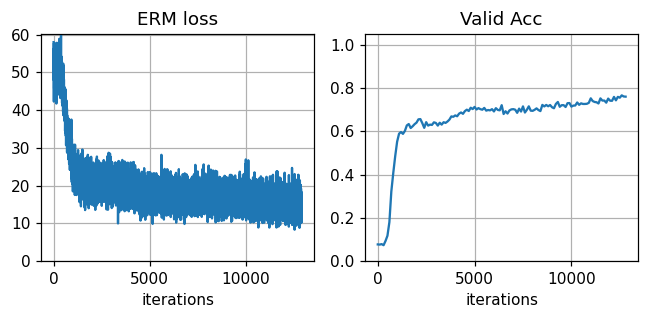

In [321]:
train_dl, valid_dl, test_dl = get_mnist_dl(batch_size_train=train_batch, batch_size_eval=valid_batch, device=DEVICE)
stats = run_experiment(train_dl, valid_dl, test_dl, num_dir, dba_flag, sw_flag, bits_storage, use_projection, max_epochs, lr)
print_stats(stats)